In [130]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [24]:
import os
from dotenv import load_dotenv
load_dotenv()
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

In [116]:
%load_ext autoreload
%autoreload 1

import sys
sys.path.append('../src')

from models import evaluation

%aimport models.evaluation

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
from pymongo import MongoClient, ASCENDING
import numpy as np

MONGO_PASSWORD = os.environ['MONGO_USER_PASSWORD']
CROWD_TANGLE = os.environ['CROWD_TANGLE_API_TOKEN']

config = {
  'host': '18.216.52.13:27017',
  'username': 'mongo_user',
  'password': MONGO_PASSWORD,
  'authSource': 'reddit_climate_news'
}

db = MongoClient(**config).reddit_climate_news

In [15]:
posts_raw = pd.DataFrame.from_records(
    db.submissions.find({},
                        {'created_utc': 1, 'url': 1, 'num_comments': 1})
)

In [99]:
all_posts = posts_raw.sort_values('num_comments', ascending=False).drop_duplicates(subset=['url'])
all_posts = all_posts[all_posts.num_comments > 1]
all_posts['viral'] = all_posts.num_comments.map(lambda x: 1 if x > 8000 else 0)
all_posts['posted_date'] = all_posts.created_utc.map(datetime.fromtimestamp)
all_posts['posted_hour'] = all_posts.posted_date.map(lambda d: d.hour)
all_posts['hour_bucket'] = all_posts.posted_hour.map(lambda h: h // 4)
all_posts['weekday'] = all_posts.posted_date.map(lambda d: d.weekday())

# By Hour

## All Days

/Users/willyraedy/opt/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.
/Users/willyraedy/opt/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  import sys


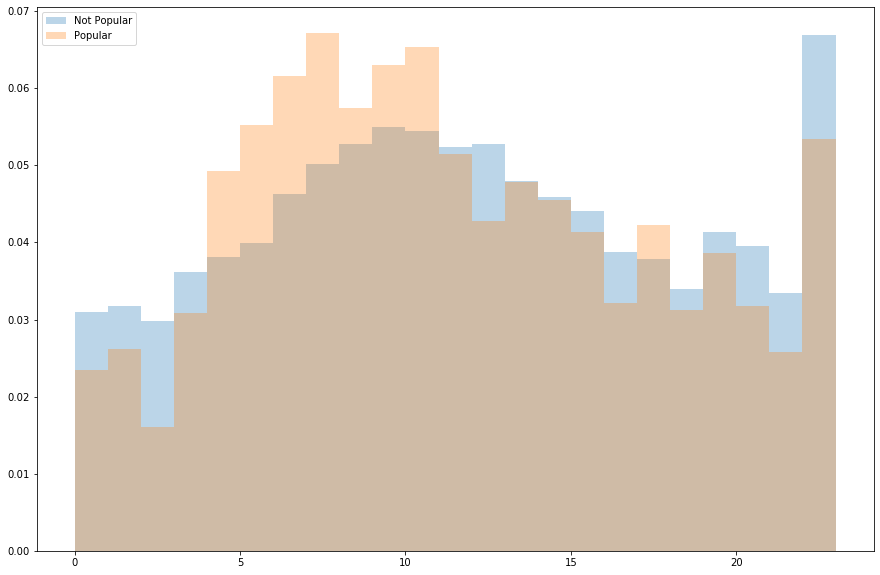

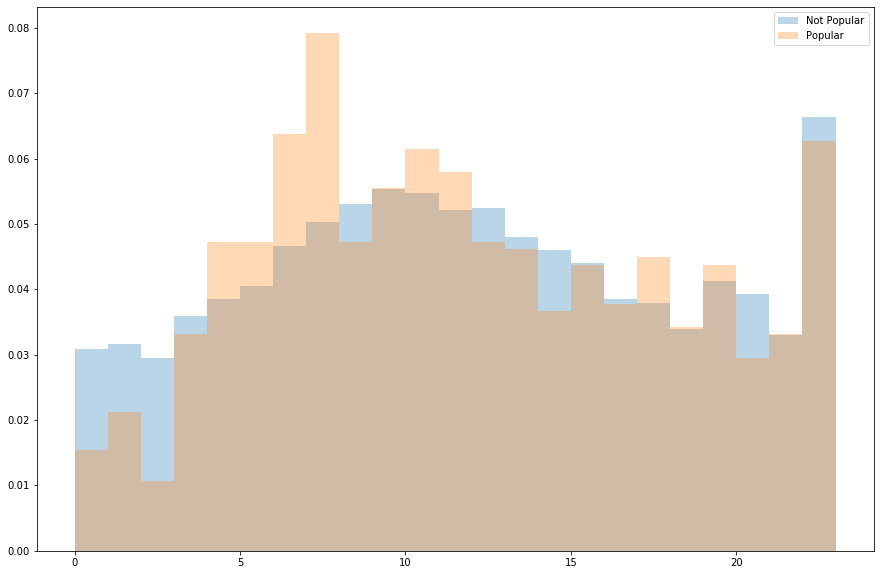

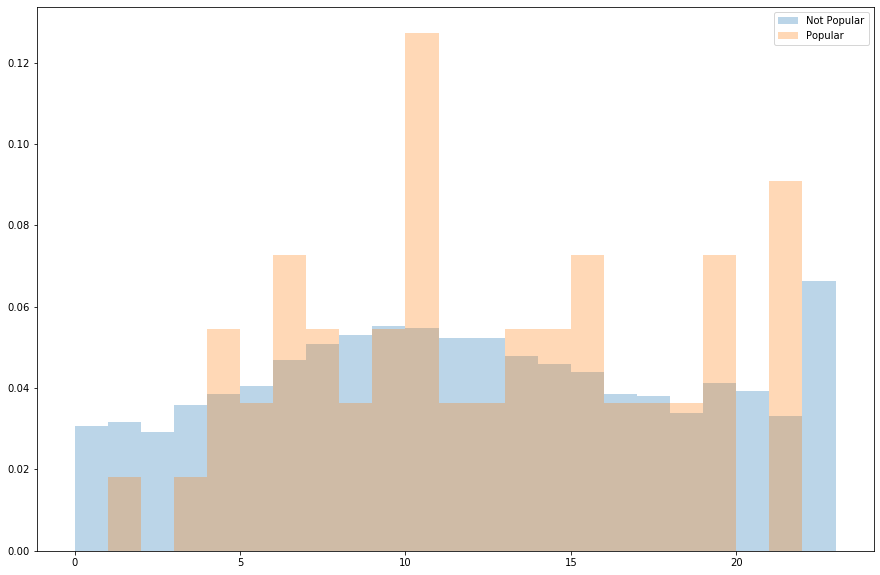

In [100]:
for thresh in [300, 1000, 8000]:
    all_posts['viral'] = all_posts.num_comments.map(lambda x: 1 if x > thresh else 0)
    plt.figure(figsize=(15, 10))
    plt.hist(all_posts[all_posts.viral == 0].posted_hour, normed=True, alpha=0.3, label='Not Popular', bins=23)
    print()
    plt.hist(all_posts[all_posts.viral == 1].posted_hour, normed=True, alpha=0.3, label='Popular',
             bins=all_posts[all_posts.viral == 1].posted_hour.max()-all_posts[all_posts.viral == 1].posted_hour.min())
    plt.legend();

In [ ]:
# highest level, don't post in hours 20-3
# do post in hours 4-10
# also right at 17
# times are in CST
# Kinda makes sense
# Post for people to see in the morning but not so early it gets lost; or post right at 5 for commute

In [ ]:
# more specifically, 6 or 7 in the morning, 10 or 11, 17

In [ ]:
# 10am hour especially good for really popular posts

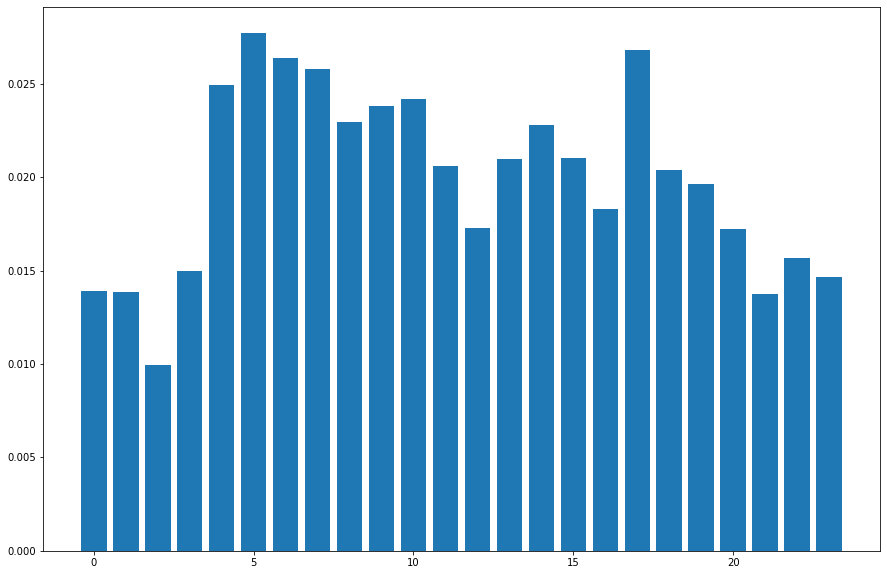

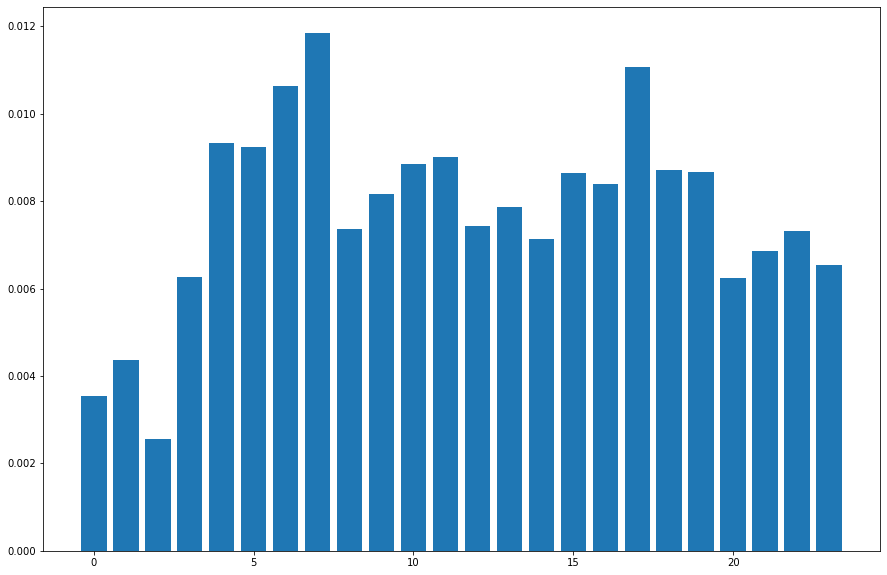

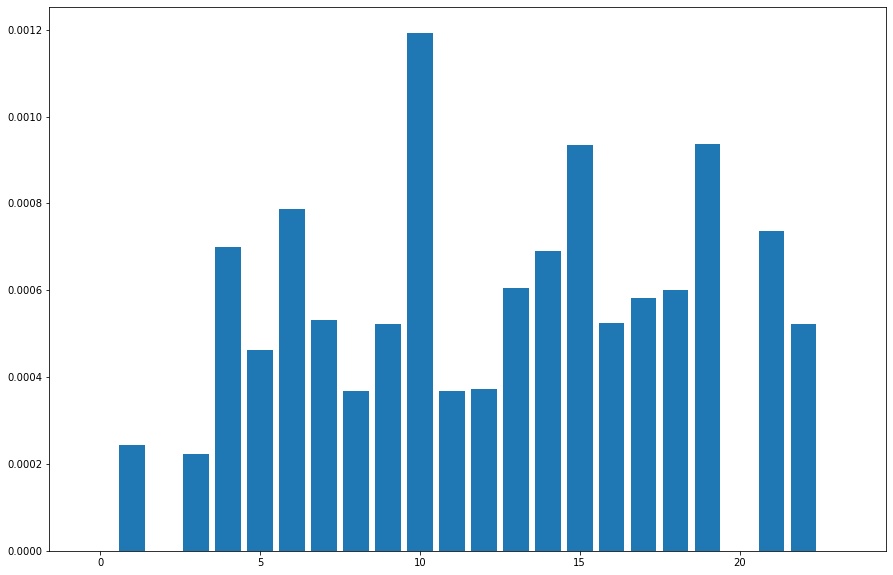

In [75]:
for thresh in [300, 1000, 8000]:
    all_posts['viral'] = all_posts.num_comments.map(lambda x: 1 if x > thresh else 0)
    perc_hour = all_posts.groupby('posted_hour').agg({'viral': 'sum', 'num_comments': 'count'})
    perc_hour['perc_viral'] = perc_hour.viral / perc_hour.num_comments

    plt.figure(figsize=(15, 10))
    plt.bar(perc_hour.index, perc_hour.perc_viral, label='Not Popular')

In [ ]:
# similar story from percent perspective: [10am, 6am] => 15 and 19 are added for most popular

In [ ]:
# at a high level, post before morning commute (6-7am), at lunch (10-11am), or even commute (15-19)

<BarContainer object of 24 artists>

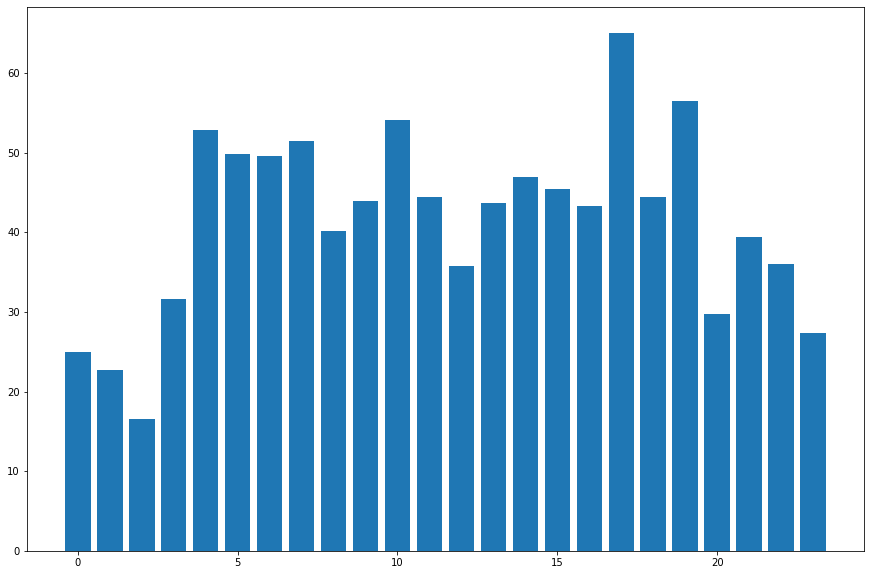

In [84]:
all_posts['viral'] = all_posts.num_comments.map(lambda x: 1 if x > thresh else 0)
perc_hour = all_posts.groupby('posted_hour').agg({'num_comments': 'mean'})

plt.figure(figsize=(15, 10))
plt.bar(perc_hour.index, perc_hour.num_comments, label='Not Popular')

## Just Weekdays

/Users/willyraedy/opt/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.
/Users/willyraedy/opt/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  import sys


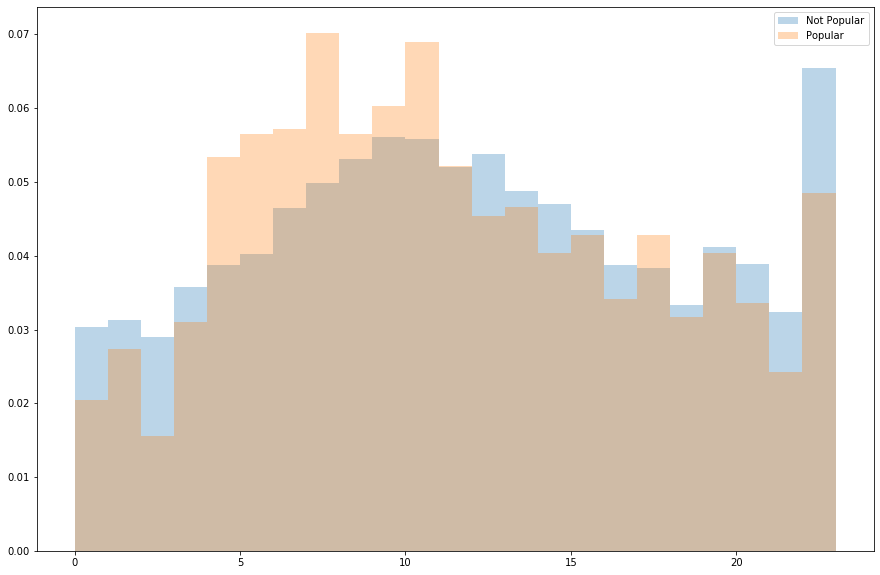

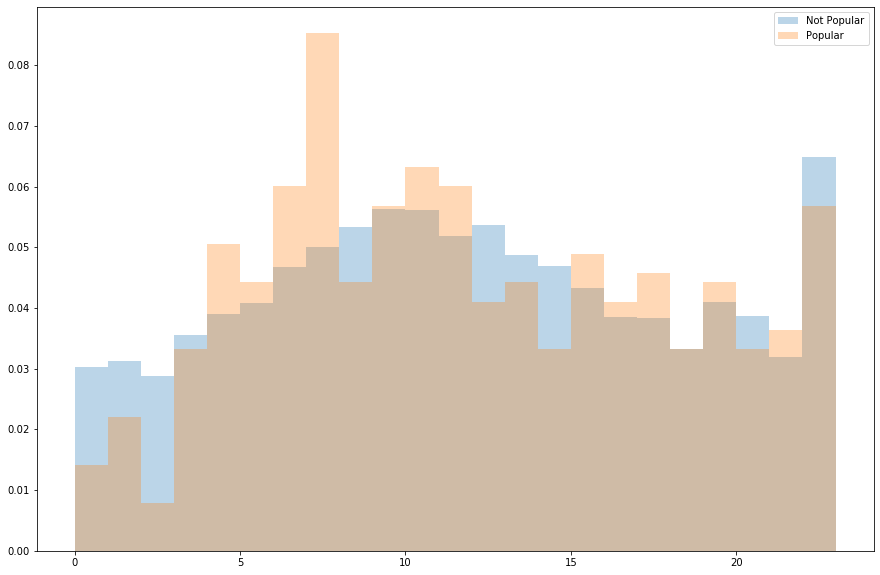

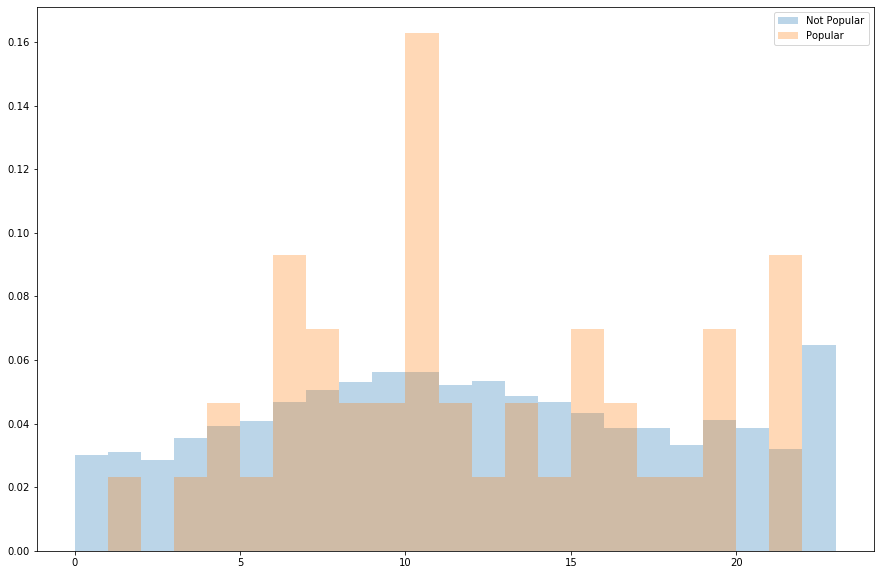

In [101]:
for thresh in [300, 1000, 8000]:
    all_posts['viral'] = all_posts.num_comments.map(lambda x: 1 if x > thresh else 0)
    plt.figure(figsize=(15, 10))
    plt.hist(all_posts[(all_posts.viral == 0) & (all_posts.weekday < 5)].posted_hour, normed=True, alpha=0.3, label='Not Popular', bins=23)
    print()
    plt.hist(all_posts[(all_posts.viral == 1) & (all_posts.weekday < 5)].posted_hour, normed=True, alpha=0.3, label='Popular',
             bins=all_posts[(all_posts.viral == 1) & (all_posts.weekday < 5)].posted_hour.max()-all_posts[(all_posts.viral == 1) & (all_posts.weekday < 5)].posted_hour.min())
    plt.legend();

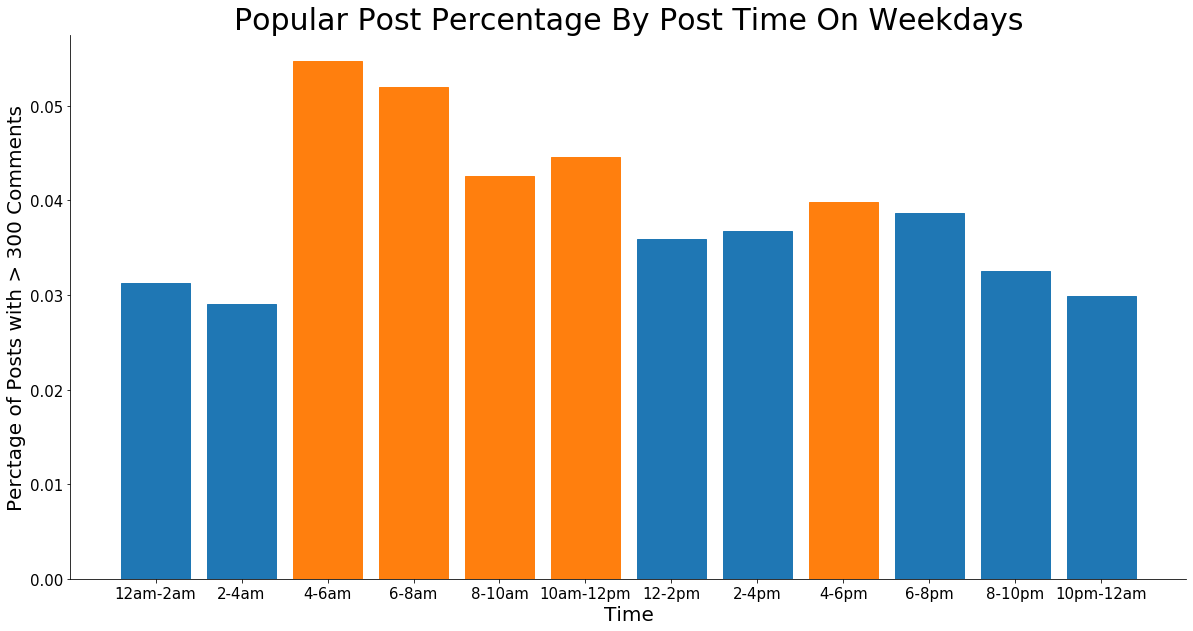

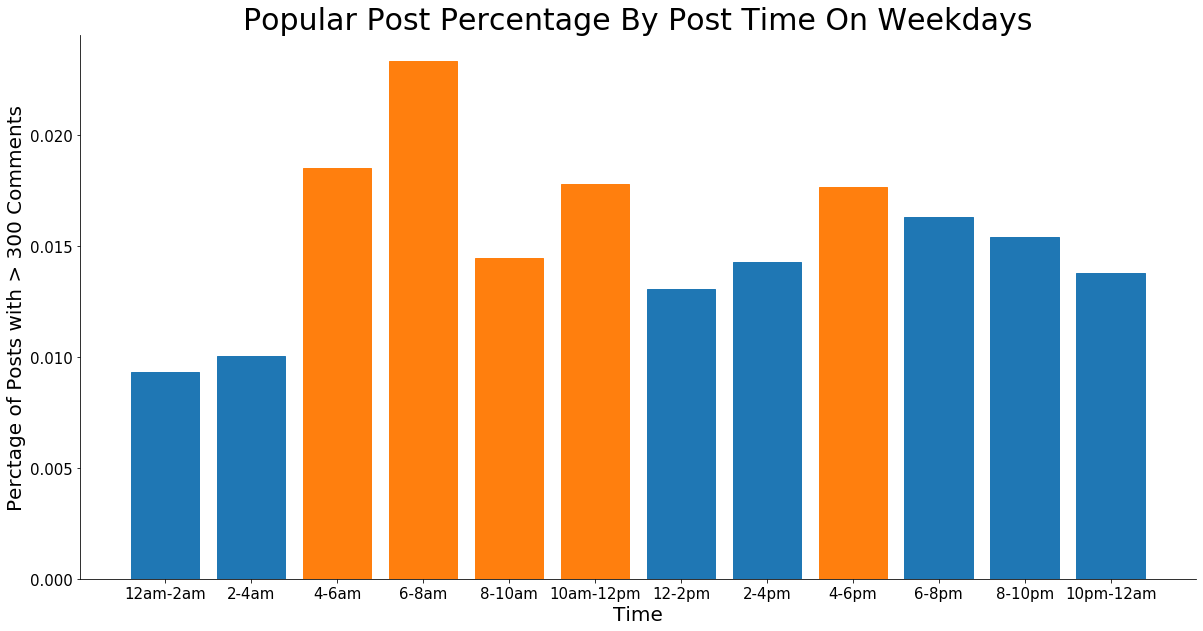

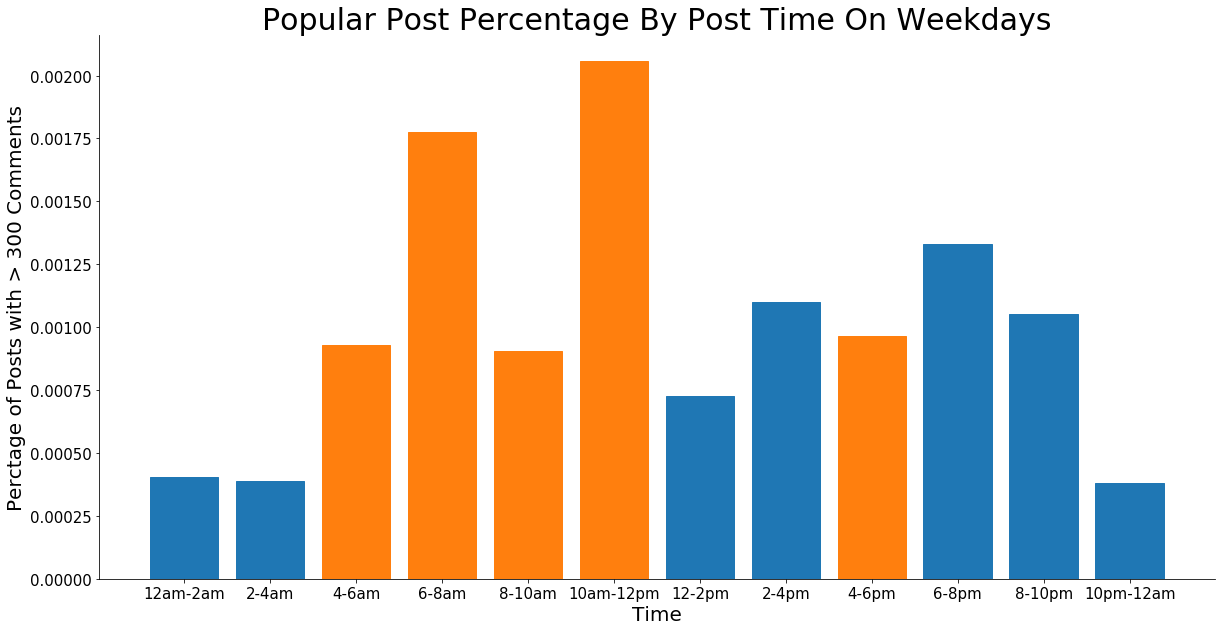

In [311]:
for thresh in [300, 1000, 8000]:
    all_posts['viral'] = all_posts.num_comments.map(
        lambda x: 1 if x > thresh else 0)
    perc_hour = all_posts[all_posts.weekday < 5].groupby(
        'two_hour_block').agg({'viral': 'sum', 'num_comments': 'count'})
    perc_hour['perc_viral'] = perc_hour.viral / perc_hour.num_comments

    plt.figure(figsize=(20, 10))
    barlist=plt.bar(perc_hour.index, perc_hour.perc_viral)
    plt.title('Popular Post Percentage By Post Time On Weekdays', fontsize=30)
    plt.yticks(fontsize=15)
    plt.ylabel('Perctage of Posts with > 300 Comments', fontsize=20)
    plt.xlabel('Time', fontsize=20)
    plt.xticks(range(12),
               labels=['12am-2am', '2-4am', '4-6am', '6-8am', '8-10am',
                '10am-12pm', '12-2pm', '2-4pm', '4-6pm', '6-8pm', '8-10pm', '10pm-12am'],
              fontsize=15)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    for i in range(12):
        barlist[i].set_color('C1' if i in [2,3,4,5,8] else 'C0')

<BarContainer object of 24 artists>

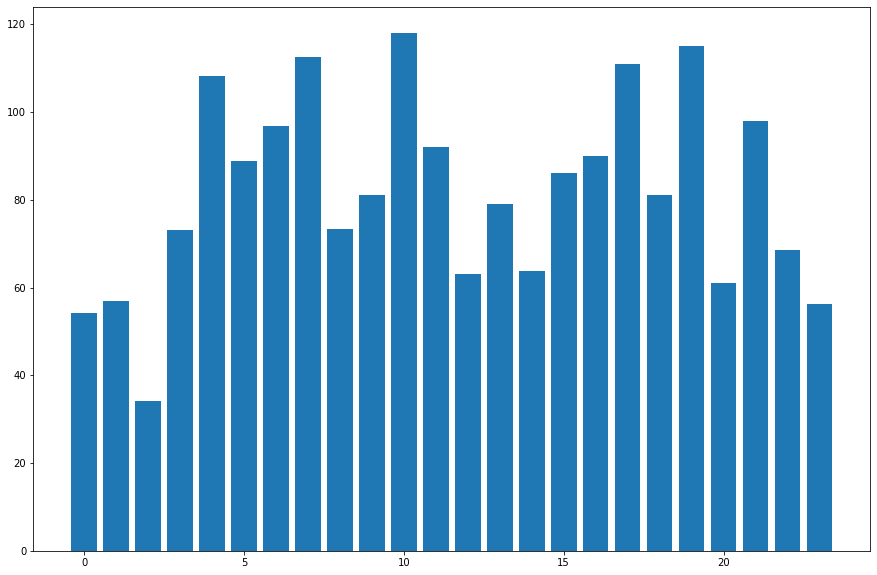

In [102]:
all_posts['viral'] = all_posts.num_comments.map(lambda x: 1 if x > thresh else 0)
perc_hour = all_posts[all_posts.weekday < 5].groupby('posted_hour').agg({'num_comments': 'mean'})

plt.figure(figsize=(15, 10))
plt.bar(perc_hour.index, perc_hour.num_comments, label='Not Popular')


## Just Weekends

/Users/willyraedy/opt/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.
/Users/willyraedy/opt/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  import sys


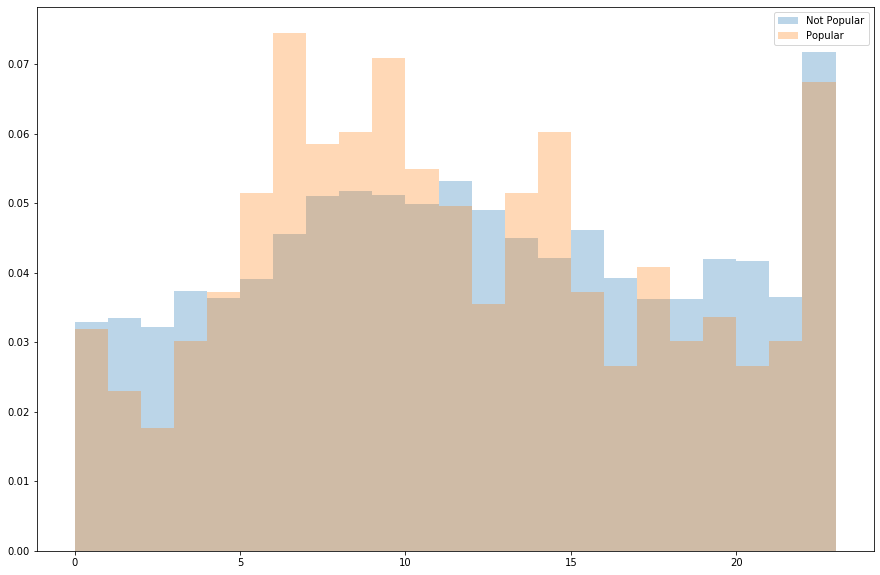

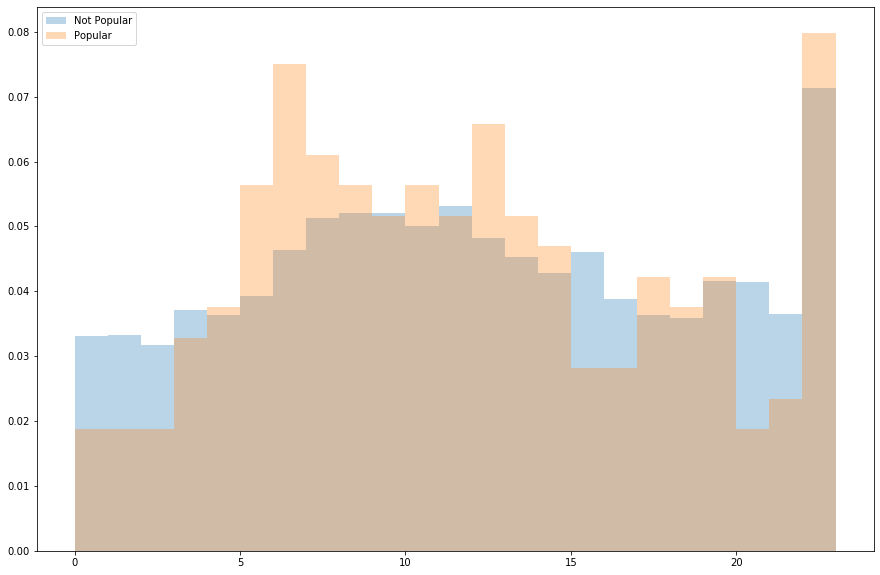

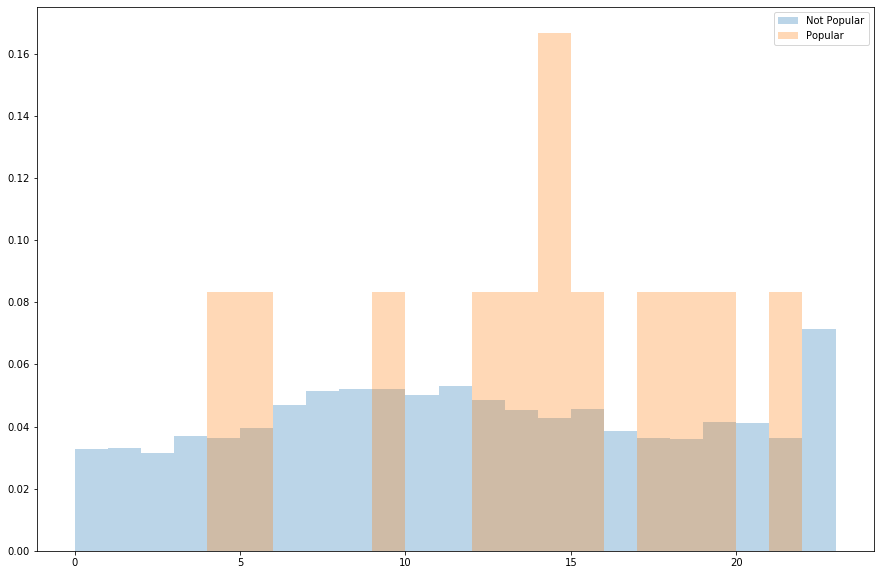

In [103]:
for thresh in [300, 1000, 8000]:
    all_posts['viral'] = all_posts.num_comments.map(lambda x: 1 if x > thresh else 0)
    plt.figure(figsize=(15, 10))
    plt.hist(all_posts[(all_posts.viral == 0) & (all_posts.weekday > 4)].posted_hour, normed=True, alpha=0.3, label='Not Popular', bins=23)
    print()
    plt.hist(all_posts[(all_posts.viral == 1) & (all_posts.weekday > 4)].posted_hour, normed=True, alpha=0.3, label='Popular',
             bins=all_posts[(all_posts.viral == 1) & (all_posts.weekday > 4)].posted_hour.max()-all_posts[(all_posts.viral == 1) & (all_posts.weekday > 4)].posted_hour.min())
    plt.legend();

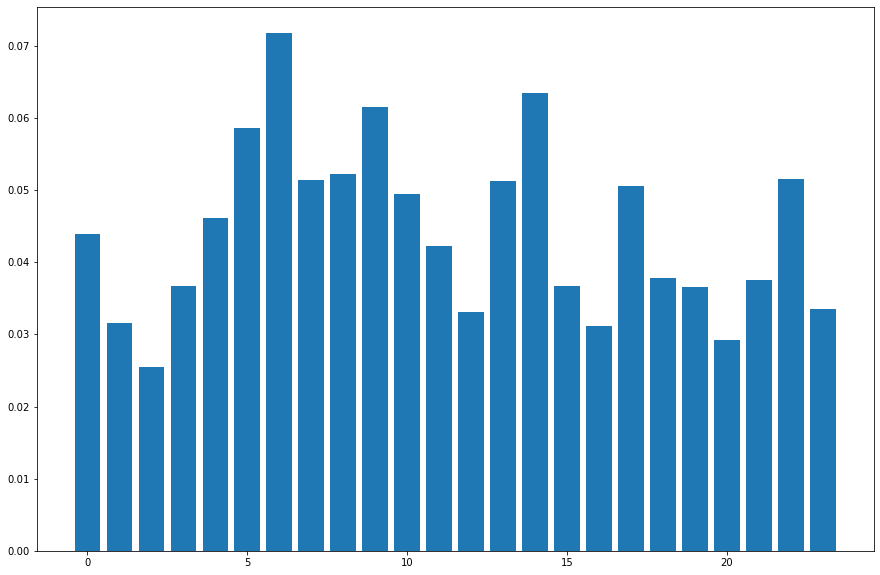

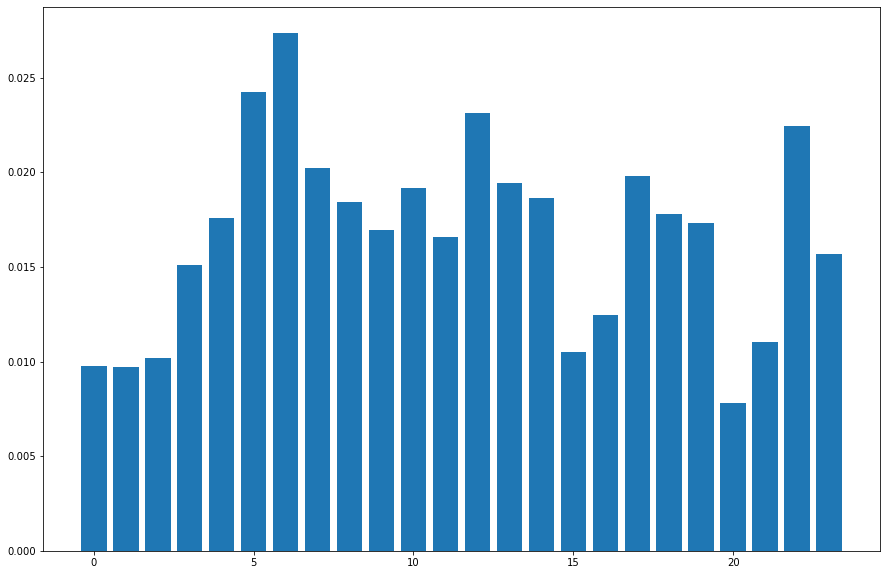

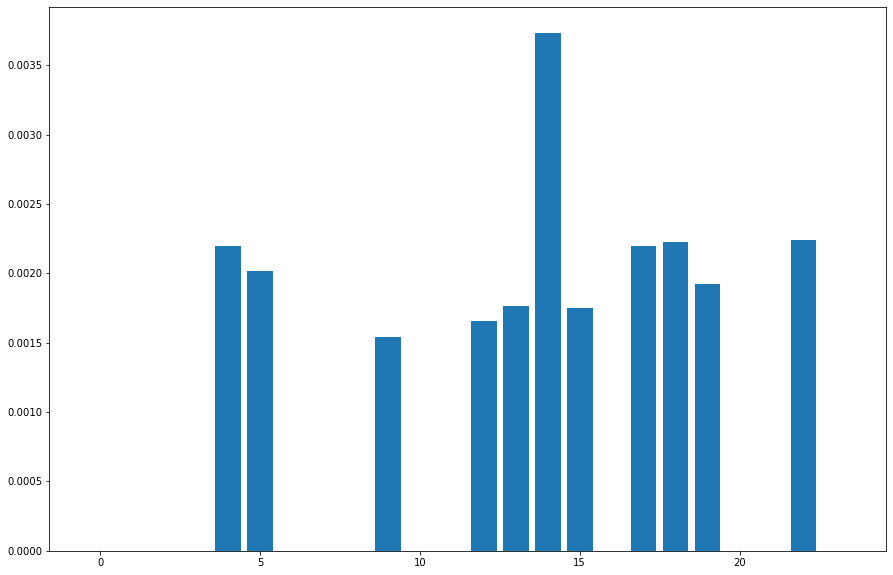

In [104]:
for thresh in [300, 1000, 8000]:
    all_posts['viral'] = all_posts.num_comments.map(lambda x: 1 if x > thresh else 0)
    perc_hour = all_posts[all_posts.weekday > 4].groupby('posted_hour').agg({'viral': 'sum', 'num_comments': 'count'})
    perc_hour['perc_viral'] = perc_hour.viral / perc_hour.num_comments

    plt.figure(figsize=(15, 10))
    plt.bar(perc_hour.index, perc_hour.perc_viral, label='Not Popular')

<BarContainer object of 24 artists>

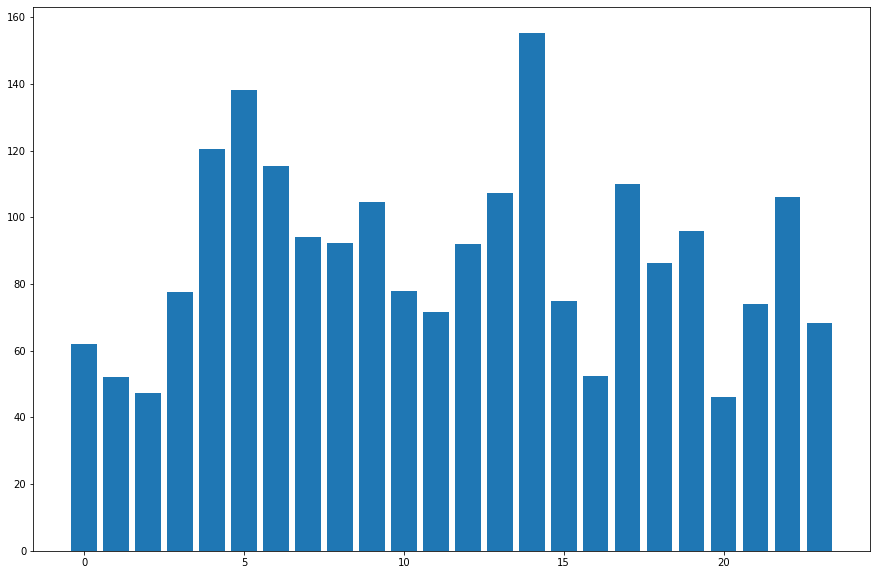

In [105]:
all_posts['viral'] = all_posts.num_comments.map(lambda x: 1 if x > thresh else 0)
perc_hour = all_posts[all_posts.weekday > 4].groupby('posted_hour').agg({'num_comments': 'mean'})

plt.figure(figsize=(15, 10))
plt.bar(perc_hour.index, perc_hour.num_comments, label='Not Popular')

# By Day of Week

/Users/willyraedy/opt/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.
/Users/willyraedy/opt/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


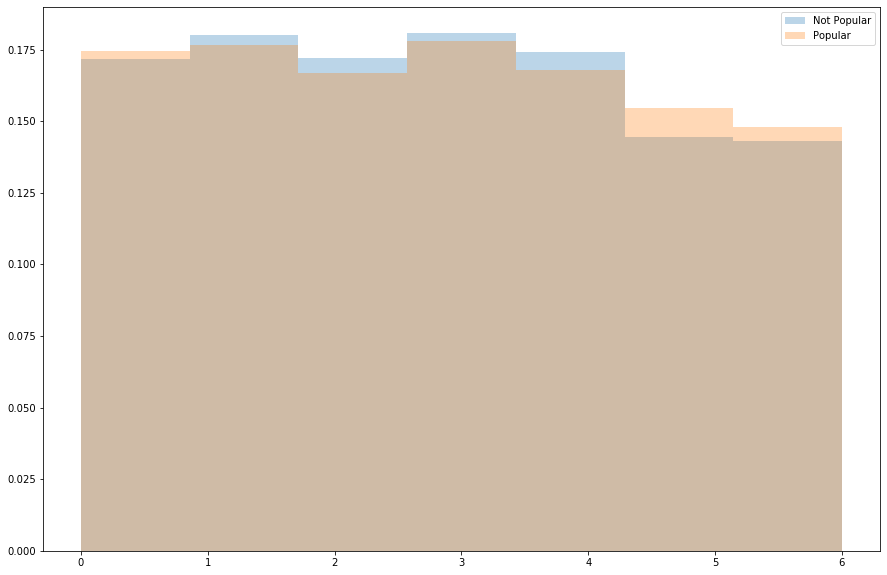

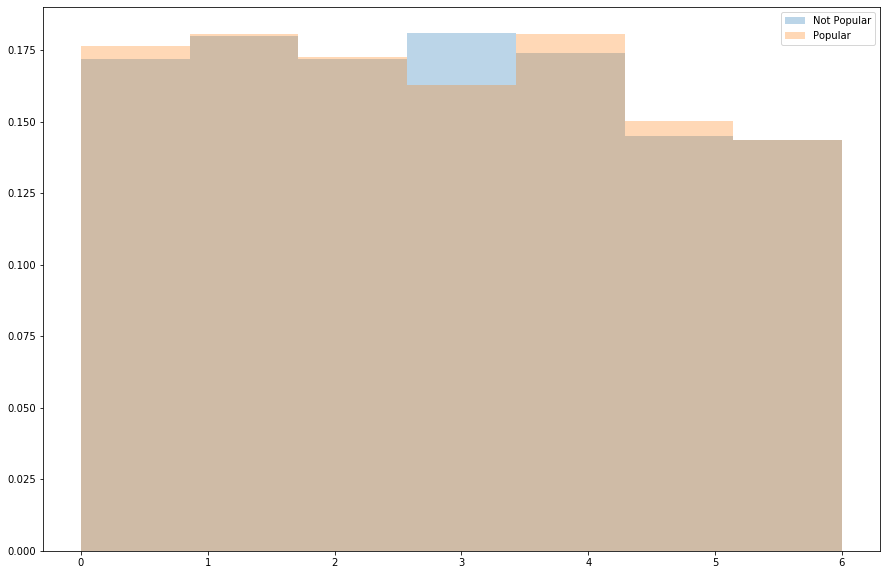

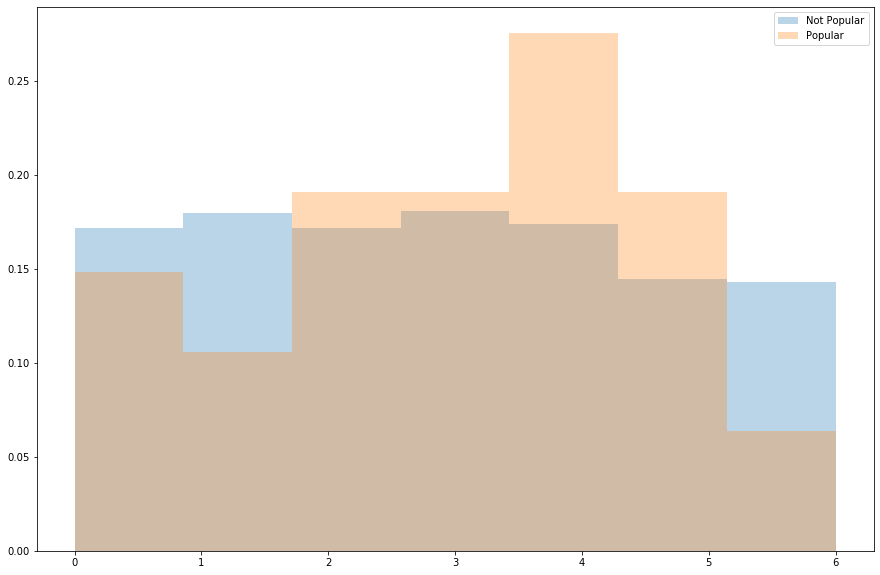

In [86]:
for thresh in [300, 1000, 8000]:
    all_posts['viral'] = all_posts.num_comments.map(lambda x: 1 if x > thresh else 0)
    plt.figure(figsize=(15, 10))
    plt.hist(all_posts[all_posts.viral == 0].weekday, normed=True, alpha=0.3, label='Not Popular', bins=7)
    print()
    plt.hist(all_posts[all_posts.viral == 1].weekday, normed=True, alpha=0.3, label='Popular', bins=7)
    plt.legend();

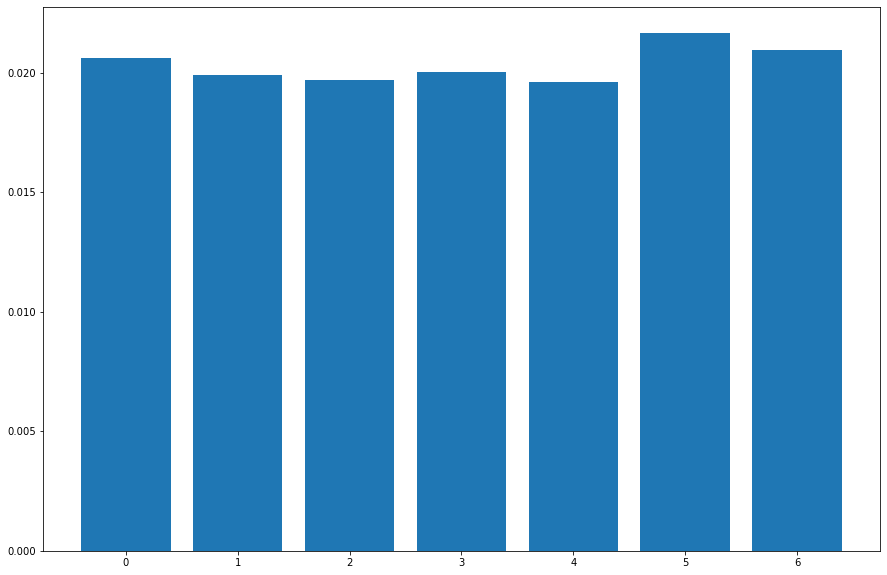

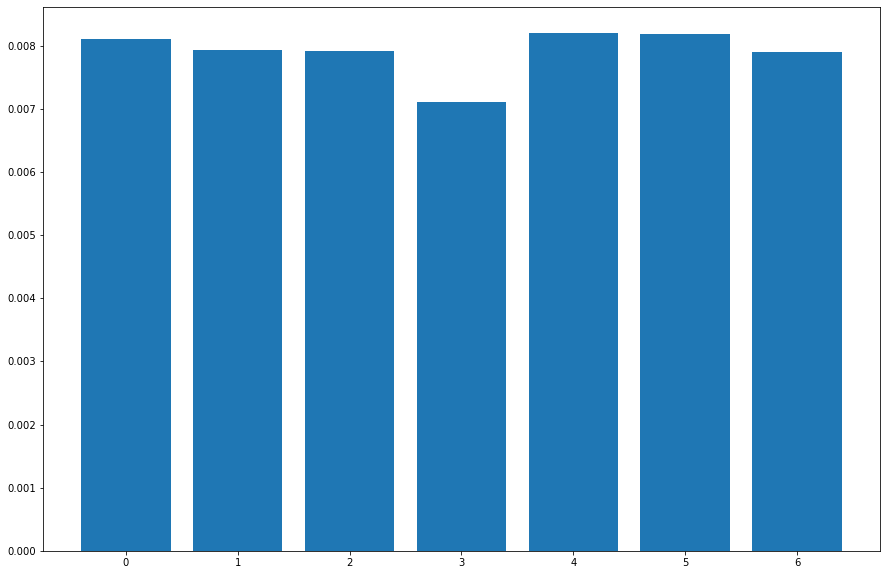

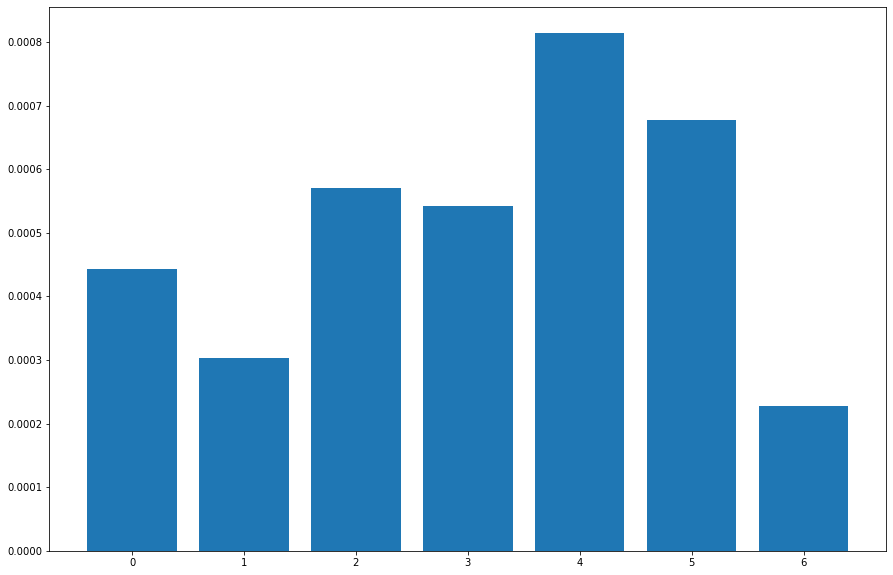

In [82]:
for thresh in [300, 1000, 8000]:
    all_posts['viral'] = all_posts.num_comments.map(lambda x: 1 if x > thresh else 0)
    perc_hour = all_posts.groupby('weekday').agg({'viral': 'sum', 'num_comments': 'count'})
    perc_hour['perc_viral'] = perc_hour.viral / perc_hour.num_comments

    plt.figure(figsize=(15, 10))
    plt.bar(perc_hour.index, perc_hour.perc_viral, label='Not Popular')

<BarContainer object of 7 artists>

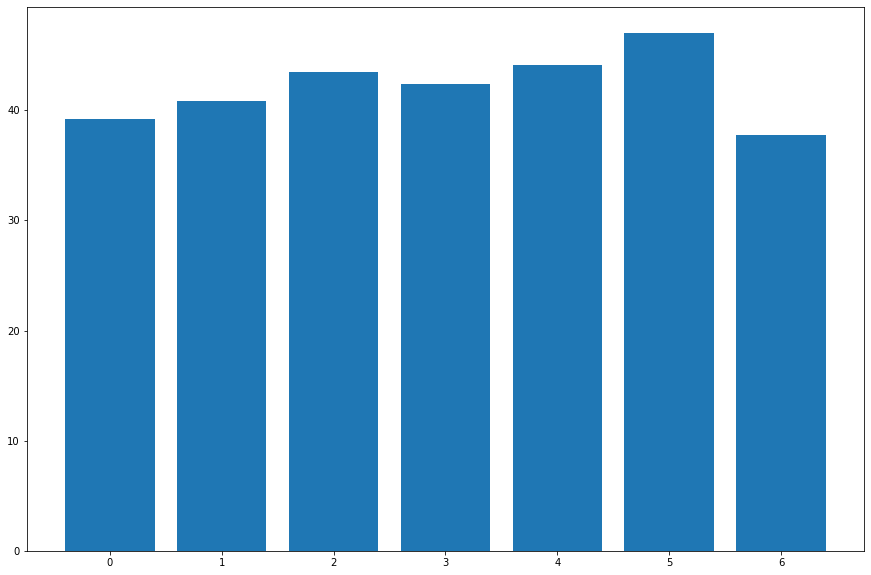

In [87]:
all_posts['viral'] = all_posts.num_comments.map(lambda x: 1 if x > thresh else 0)
perc_hour = all_posts.groupby('weekday').agg({'num_comments': 'mean'})

plt.figure(figsize=(15, 10))
plt.bar(perc_hour.index, perc_hour.num_comments, label='Not Popular')

In [ ]:
# slightly more posts on weekdays but not really much of a difference in terms of post popularity
# would be great to get statistical error bars

# Modeling

In [119]:
def print_results(cv_res, scoring):
    for s in scoring:
        print('test_' + s, np.mean(cv_res['test_' + s]))
        print('train_' + s, np.mean(cv_res['train_' + s]))

In [ ]:
# things to try
    - every hour, every day
    - two hour blocks, weekend vs weekday
    - two hour blocks
    - four hour blocks
# regression vs. classification (idk)
    - suspect I will not have linear relationships


In [174]:
all_posts['viral'] = all_posts.num_comments.map(lambda x: 1 if x > 300 else 0)
all_posts['two_hour_block'] = all_posts.posted_hour.map(lambda x: x // 2)
all_posts['posted_on_weekend'] = all_posts.weekday.map(lambda x: 1 if x > 4 else 0)

In [238]:
model_data = pd.get_dummies(all_posts, columns=['two_hour_block', 'posted_on_weekend'])
X, y = model_data.loc[:, 'two_hour_block_0':], model_data.viral
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## RF

In [211]:
rf_scoring = ['roc_auc', 'recall', 'precision', 'accuracy']

for md in [1, 2]:
    for mid in [0, 0.0001, 0.001]:
        cv_res = evaluation.cross_validate(
            estimator=RandomForestClassifier,
            X=X_train,
            y=y_train,
            scoring=rf_scoring,
            fit_params={
                'max_depth': md,
                'n_estimators': 200,
                'random_state': 42,
                'min_impurity_decrease': mid
            },
            oversample=True,
            cv=5
        #         show_conf_matrices=True
        )
        print('********', md, mid, '********')
        print_results(cv_res, rf_scoring)

******** 1 0 ********
test_roc_auc 0.5369843811796591
train_roc_auc 0.5614853842918378
test_recall 0.43610315186246423
train_recall 0.46063278648081907
test_precision 0.04789906392731648
train_precision 0.5520742106657404
test_accuracy 0.6093661305581834
train_accuracy 0.5389447391143456
******** 1 0.0001 ********
test_roc_auc 0.5352360247591048
train_roc_auc 0.5605145002166578
test_recall 0.43209169054441265
train_recall 0.45771555445910944
test_precision 0.047836255964029586
train_precision 0.5524189130685482
test_accuracy 0.6116130558183539
train_accuracy 0.5387227087701986
******** 1 0.001 ********
test_roc_auc 0.506314646191713
train_roc_auc 0.5205720105696219
test_recall 0.6120343839541548
train_recall 0.6284075490317009
test_precision 0.04273379218522533
train_precision 0.5386809802409254
test_accuracy 0.40338221381267736
train_accuracy 0.5122055014185272
******** 2 0 ********
test_roc_auc 0.5360687622532864
train_roc_auc 0.5660313911515813
test_recall 0.433810888252149
train_re

In [239]:
cv_res = evaluation.cross_validate(
    estimator=RandomForestClassifier,
    X=X_train,
    y=y_train,
    scoring=rf_scoring,
    fit_params={
        'max_depth': 2,
        'n_estimators': 200,
        'random_state': 42,
        'min_impurity_decrease': 0
    },
    oversample=True,
    cv=5
#         show_conf_matrices=True
)

print_results(cv_res, rf_scoring)

test_roc_auc 0.5405990365961285
train_roc_auc 0.5574391632847814
test_recall 0.4034383954154728
train_recall 0.4203527815468114
test_precision 0.04791115332538185
train_precision 0.5504089003019091
test_accuracy 0.6447492904446547
train_accuracy 0.5382786480819045


In [ ]:
test_roc_auc 0.5479287240889492
train_roc_auc 0.5548436232401619
test_recall 0.4429799426934097
train_recall 0.45566794128530896
test_precision 0.048121064678681255
train_precision 0.5489541055373985
test_accuracy 0.6139072847682119
train_accuracy 0.5391575181941533

In [240]:
input_cols = ['two_hour_block', 'posted_on_weekend']
test_data = all_posts.groupby(input_cols).agg('mean')\
    .reset_index().drop_duplicates(subset=input_cols)[input_cols]
test_data = pd.get_dummies(test_data, columns=input_cols)

In [241]:
rf = RandomForestClassifier(**{
        'max_depth': 2,
        'n_estimators': 200,
        'random_state': 42,
        'min_impurity_decrease': 0
    })
rf.fit(X, y)
test_data['pred_proba'] = rf.predict_proba(test_data)[:, 1]

## XGBoost

In [138]:
xg_scoring = ['roc_auc', 'recall', 'precision', 'accuracy']

for md in [2, 3]:
    for g in [0, 1, 3, 5]:
        for n in [15, 50, 100]:
            cv_res = evaluation.cross_validate(
                estimator=XGBClassifier,
                X=X_train,
                y=y_train,
                scoring=xg_scoring,
                fit_params={
                    'max_depth': md,
                    'n_estimators': n,
                    'random_state': 42,
                    'gamma': g
                },
                oversample=True,
                cv=5
            #         show_conf_matrices=True
            )
            print('*****', md, g, n, '******')
            print_results(cv_res, xg_scoring)

***** 2 0 15 ******
test_roc_auc 0.5329265840161479
train_roc_auc 0.5524347761709827
test_recall 0.33065902578796563
train_recall 0.3434809423954607
test_precision 0.04998434564573919
train_precision 0.559171680810018
test_accuracy 0.7107379375591296
train_accuracy 0.5359349944492413
***** 2 0 50 ******
test_roc_auc 0.5390961435216586
train_roc_auc 0.5581808096376684
test_recall 0.44011461318051576
train_recall 0.46625138768965096
test_precision 0.047029492333151915
train_precision 0.5476036984255038
test_accuracy 0.6067644276253548
train_accuracy 0.5399500431725669
***** 2 0 100 ******
test_roc_auc 0.5391572177710515
train_roc_auc 0.559292056287247
test_recall 0.48022922636103155
train_recall 0.5146540027137042
test_precision 0.0460484727852396
train_precision 0.5457433729681682
test_accuracy 0.5655392620624408
train_accuracy 0.5421333415566794
***** 2 1 15 ******
test_roc_auc 0.5329265840161479
train_roc_auc 0.5524347761709827
test_recall 0.33065902578796563
train_recall 0.3434809423

## Just Guess the Mean

In [148]:
model_data.groupby(['posted_on_weekend', 'hour_bucket']).agg({'num_comments': 'mean'}).sort_values('num_comments', ascending=False)

num_comments
posted_on_weekend hour_bucket              
1                 1              115.314194
                  3              106.442493
0                 1              101.954134
                  4              100.183573
                  2               91.409143
1                 2               86.579923
                  4               85.976390
                  5               72.651776
0                 3               72.496588
                  5               70.456375
1                 0               60.457092
0                 0               55.651287

## Perc of Posts that pass thresh

In [191]:
all_posts['viral'] = all_posts.num_comments.map(lambda x: 1 if x > 300 else 0)
perc_hour = all_posts.groupby(['posted_on_weekend', 'two_hour_block']).agg({'viral': 'sum', 'num_comments': 'count'})
perc_hour['perc_viral'] = perc_hour.viral / perc_hour.num_comments

perc_hour.perc_viral.sort_values(ascending=False)

posted_on_weekend  two_hour_block
1                  3                 0.061125
                   4                 0.056879
0                  2                 0.054731
1                  2                 0.052632
0                  3                 0.052044
1                  7                 0.049684
                   5                 0.045772
0                  5                 0.044582
1                  11                0.042553
0                  4                 0.042534
1                  6                 0.041845
                   8                 0.040555
0                  8                 0.039871
                   9                 0.038641
1                  0                 0.037713
                   9                 0.037152
0                  7                 0.036803
                   6                 0.035870
1                  10                0.033161
0                  10                0.032586
1                  1                 0.031542


,posted_on_weekend,posted_hour
0,0,0
1,0,1
2,0,2
3,0,3
4,0,4
5,0,5
6,0,6
7,0,7
8,0,8
9,0,9


# RF Model Rankings

In [242]:
test_data[test_data.posted_on_weekend_0 == 1].sort_values('pred_proba', ascending=False)

,two_hour_block_0,two_hour_block_1,two_hour_block_2,two_hour_block_3,two_hour_block_4,two_hour_block_5,two_hour_block_6,two_hour_block_7,two_hour_block_8,two_hour_block_9,two_hour_block_10,two_hour_block_11,posted_on_weekend_0,posted_on_weekend_1,pred_proba
4,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0.044850
6,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0.044349
10,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0.040980
8,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0.040902
16,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0.040419
14,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0.040254
18,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0.040203
12,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0.040023
20,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0.038760
0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0.038404


In [243]:
test_data[test_data.posted_on_weekend_1 == 1].sort_values('pred_proba', ascending=False)

,two_hour_block_0,two_hour_block_1,two_hour_block_2,two_hour_block_3,two_hour_block_4,two_hour_block_5,two_hour_block_6,two_hour_block_7,two_hour_block_8,two_hour_block_9,two_hour_block_10,two_hour_block_11,posted_on_weekend_0,posted_on_weekend_1,pred_proba
7,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0.047482
5,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0.045940
9,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0.043943
11,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0.043182
15,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0.042650
17,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0.042549
13,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0.042195
19,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0.041919
23,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0.041823
1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0.040862


In [ ]:
# weekend: 2, 3, 5, 4, 8, 7
# weekday: 3, 2, 5, 4, 8, 7, 9

In [ ]:
# Recommendation:
# Weekday: before 8am, between 10-12pm, 4-6pm
# Weekend: before noon (earlier the better), 2-6pm